> 📝 **Nota:**  
> La solución presentada en este notebook se basa en trabajos previos de la comunidad de Kaggle.  
> En particular, se han tomado ideas y enfoques de los siguientes notebooks:
>
> - 📘 [**biketest** por ensari](https://www.kaggle.com/code/ensari/biketest)
> - 📗 [**Bike Sharing Demand** por jaeraklim](https://www.kaggle.com/code/jaeraklim/bike-sharing-demand)
>
> Estas soluciones sirvieron como guía para realizar la ingeniería de características, entrenar modelos como Random Forest, XGBoost y LightGBM, y estructurar la lógica de predicción para el envío de resultados a la competencia.


## Importing the libraries

In [40]:
import numpy as np  # Linear algebra, for mathematical computations
import pandas as pd  # Data processing, for reading CSV files (e.g. pd.read_csv)
import matplotlib.pyplot as plt  # Visualization, for creating plots and graphs
import seaborn as sns  # Visualization, for creating heatmaps and advanced plots

from sklearn.model_selection import train_test_split  # For splitting the dataset into training and testing sets
from sklearn.linear_model import LinearRegression  # Regression model
from sklearn.metrics import mean_squared_error, r2_score  # For model evaluation, error metrics, and R-squared
from sklearn.metrics import mean_squared_log_error  # For calculating the RMSLE (Root Mean Squared Logarithmic Error)

from sklearn.ensemble import RandomForestRegressor  # Ensemble model for regression using decision trees
from sklearn.preprocessing import StandardScaler  # For feature scaling (standardization)

import xgboost as xgb  # Extreme Gradient Boosting, optimized for performance
import lightgbm as lgb  # Light Gradient Boosting Machine, fast and efficient boosting framework

from google.colab import drive  # For mounting Google Drive to access datasets in Google Colab

## Accessing Google Drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


## Loading the dataset

## If you uploaded files directly to the Google Colab runtime (using the folder icon → "Upload Files" button), you can upload them to a DataFrame as follows:

In [ ]:
"""train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')"""

In [3]:
# Load the train and test datasets from drive

train_path = '/content/drive/MyDrive/data_bike_sharing_demand/train.csv' # change the path to the path where the file is stored
test_path = '/content/drive/MyDrive/data_bike_sharing_demand/test.csv'

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

## Training data description

In [4]:
# Display the first few rows to understand the structure of the data
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


## Checking for the null values

In [5]:
# Check for missing values in the train dataset
missing_values = train.isnull().sum()

# Display the columns with missing values
print(missing_values)

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64


**There aren't missing data**

## Lets first explore the output value (Count)

<Axes: >

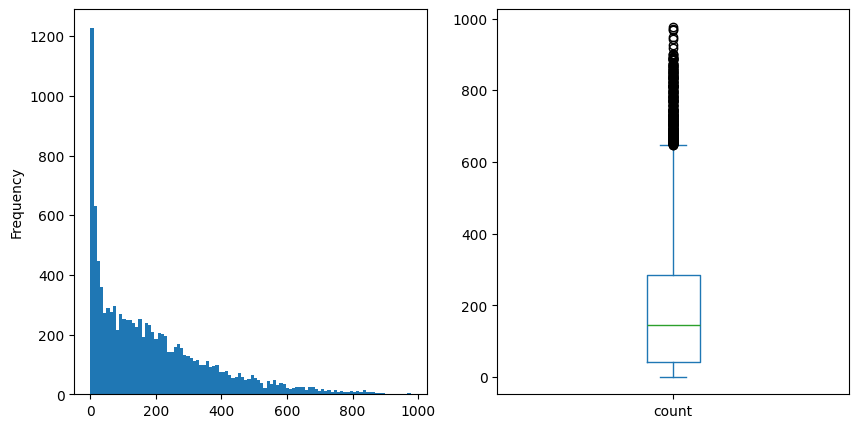

In [6]:
fig,ax = plt.subplots(1, 2)
fig.set_size_inches(10,5)
train['count'].plot(kind = 'hist', bins=100, ax =ax[0])
train['count'].plot(kind = 'box', ax =ax[1])

## As we can see that it contains the outliers. It happens when we have more rented bikes than usual. So we need to remove the outliers as they can affect our models for predictions.

In [7]:
print('Before removing the outliers ', train.shape)
train = train[abs(train['count'] - train['count'].mean()) < 3*train['count'].std()]
print('After removing the outliers ', train.shape)
train.reset_index(drop = True, inplace = True)

Before removing the outliers  (10886, 12)
After removing the outliers  (10739, 12)


### Lets visualize the distribution of the output variable

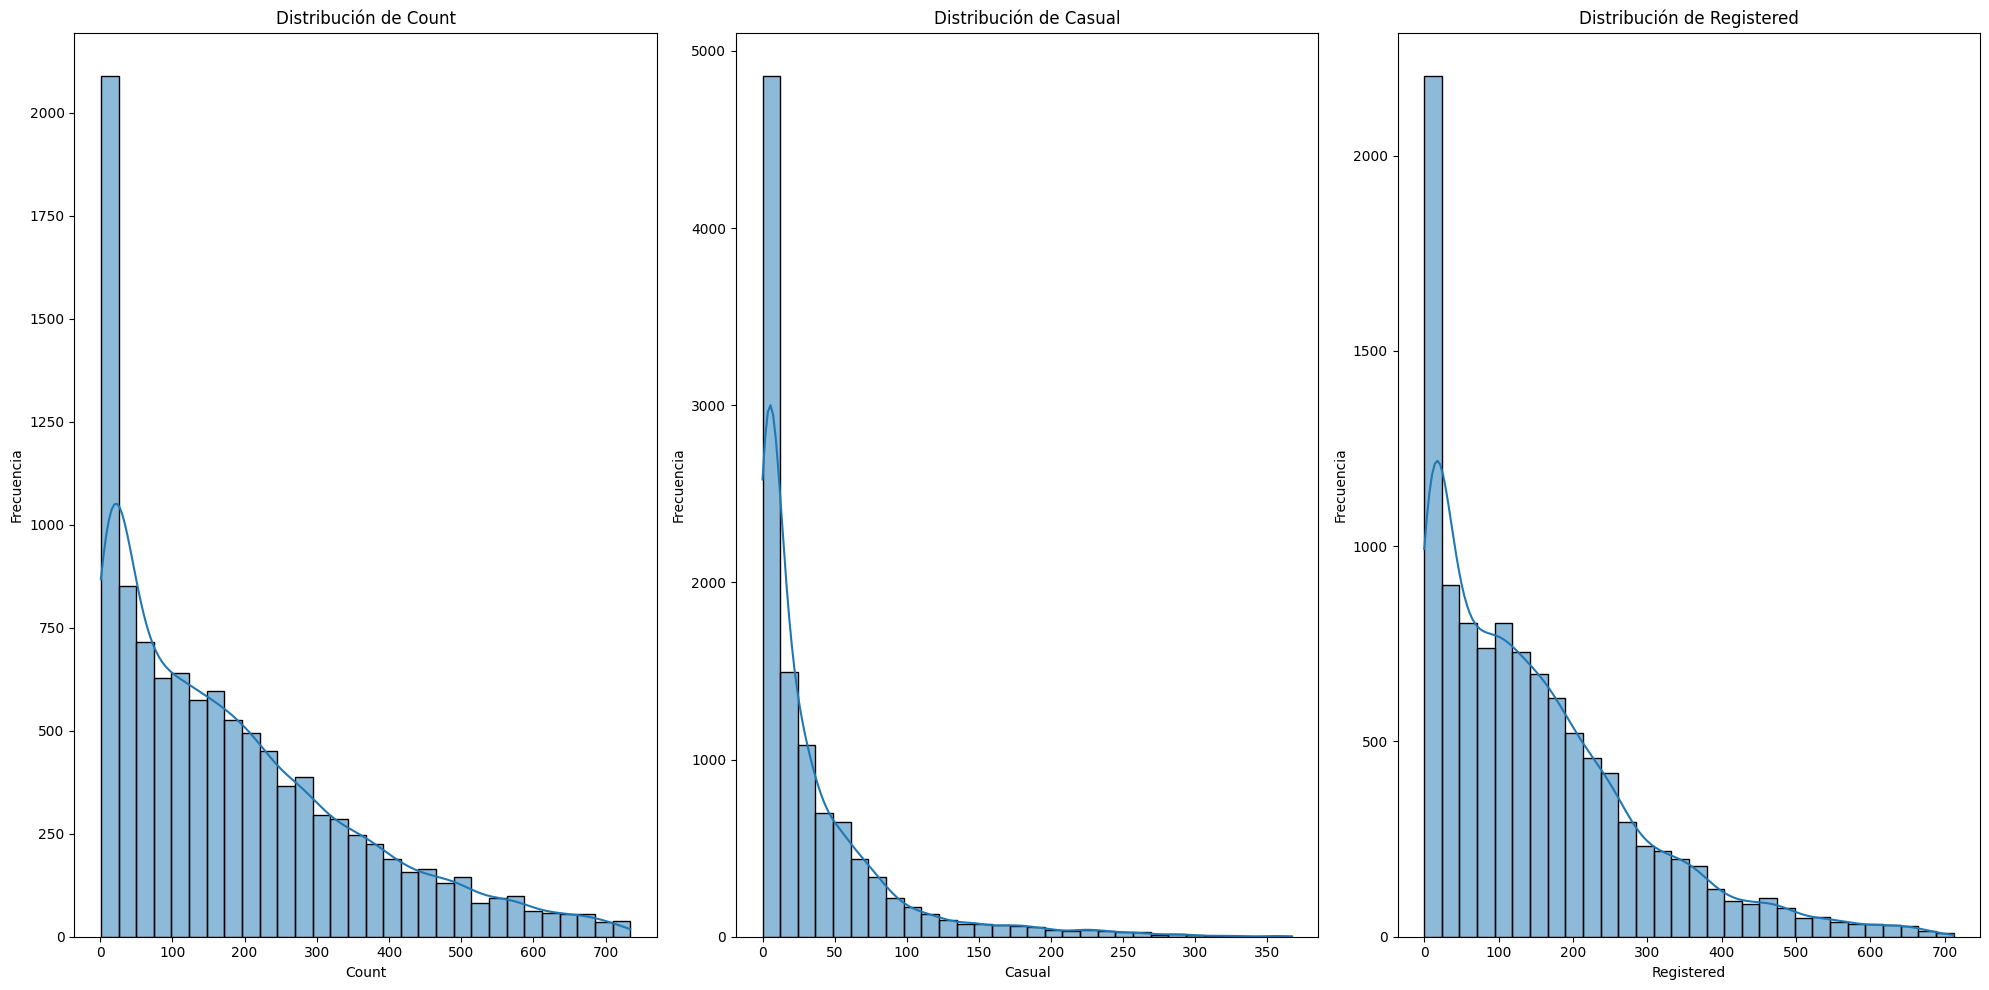

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(20, 10))

# Chart for "count"
sns.histplot(train["count"], ax=ax[0], kde=True, bins=30)
ax[0].set_title('Distribución de Count')
ax[0].set_xlabel('Count')
ax[0].set_ylabel('Frecuencia')

# Chart for "casual"
sns.histplot(train["casual"], ax=ax[1], kde=True, bins=30)
ax[1].set_title('Distribución de Casual')
ax[1].set_xlabel('Casual')
ax[1].set_ylabel('Frecuencia')

# Chart for "registered"
sns.histplot(train["registered"], ax=ax[2], kde=True, bins=30)
ax[2].set_title('Distribución de Registered')
ax[2].set_xlabel('Registered')
ax[2].set_ylabel('Frecuencia')

plt.tight_layout()  # Adjust spacing to avoid overlapping
plt.show()

## As most of the machine learning models work best when the output variable is normally distributed, we will apply the log transformation to "Count" and "Registered" to make it more normally distributed

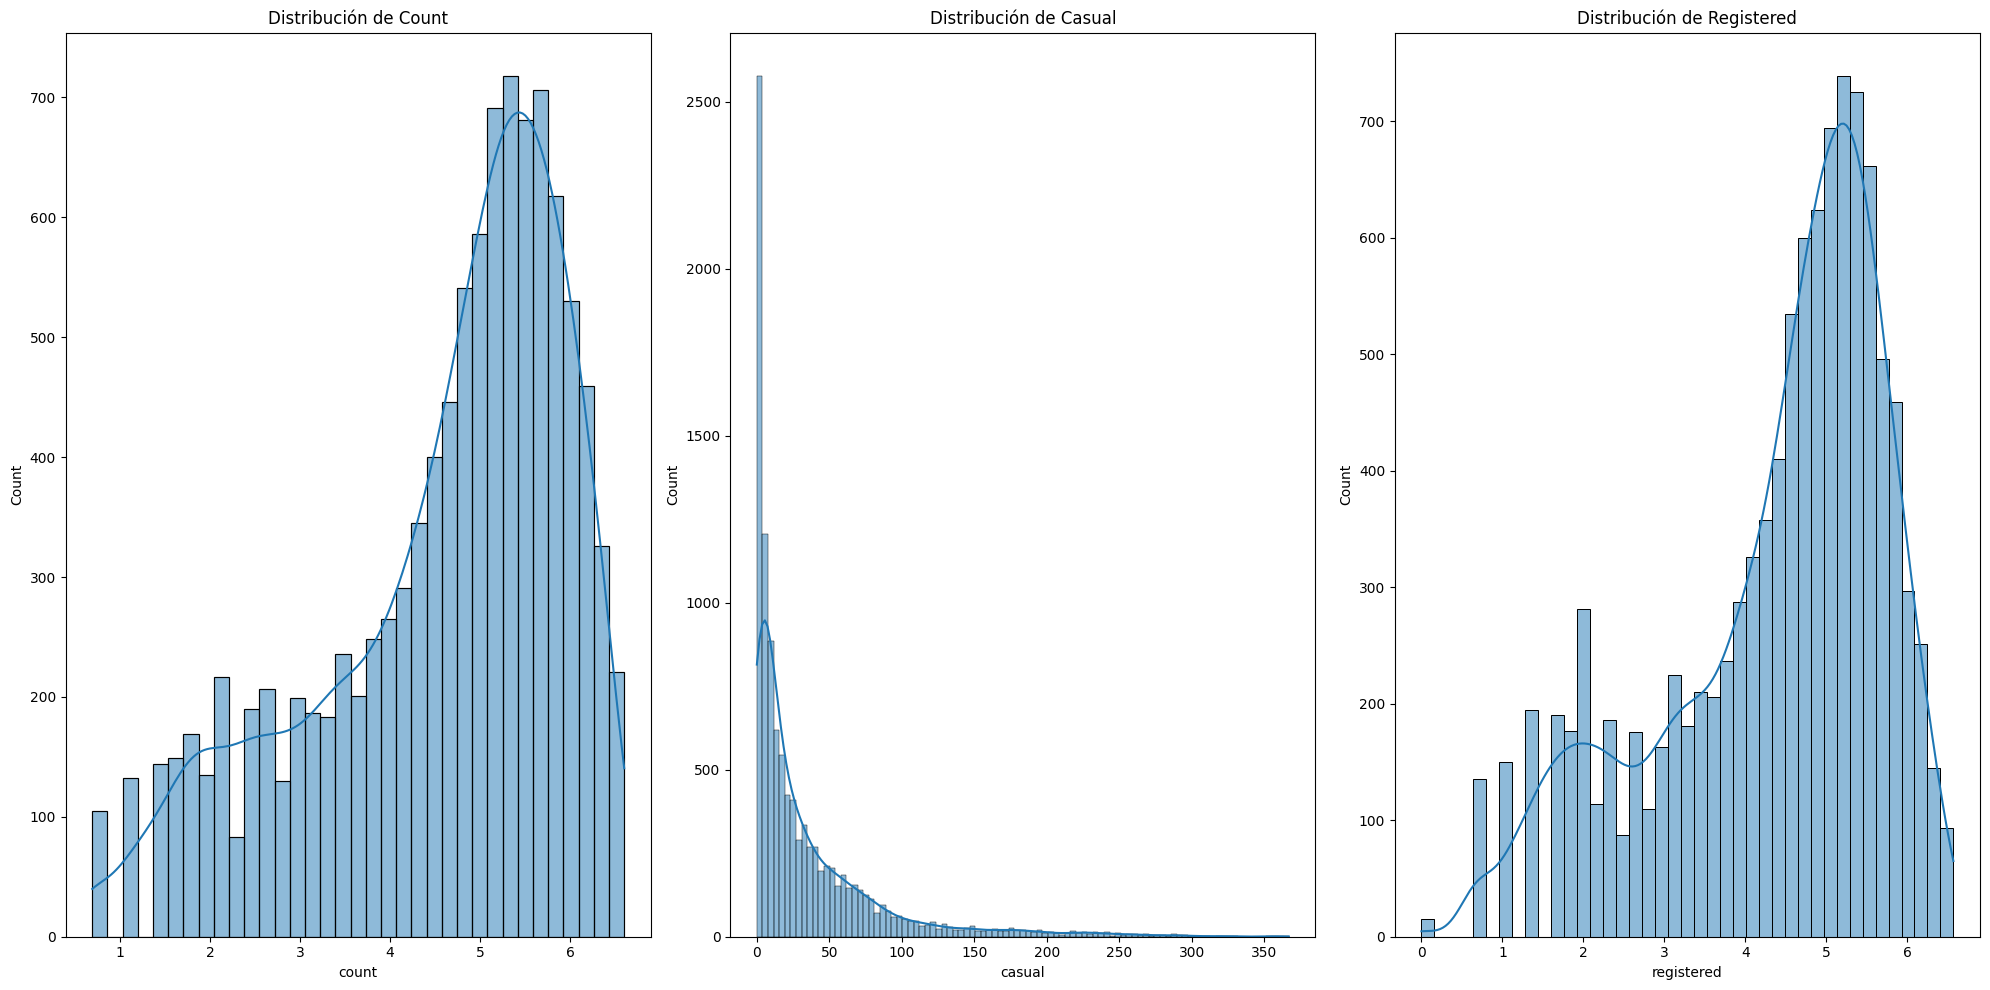

In [9]:
train['count'] = np.log(train['count'] + 1) ## We have added 1 by taking the logarithm as np.log(0) is infinite
train['registered'] = np.log(train['registered'] + 1)

fig, ax = plt.subplots(1, 3, figsize=(20,10))

# Usar sns.histplot() en vez de sns.displot()
sns.histplot(train["count"], ax=ax[0], kde=True)
ax[0].set_title('Distribución de Count')

sns.histplot(train["casual"], ax=ax[1], kde=True)
ax[1].set_title('Distribución de Casual')

sns.histplot(train["registered"], ax=ax[2], kde=True)
ax[2].set_title('Distribución de Registered')

plt.tight_layout()  # Adjust spacing to avoid overlapping
plt.show()

## Now the distribution is more normally distributed but remember we have added 1 before taking the log as np.log(0) will give infinity

## Extracting the month, hour, year, day from the datetime column in train.

In [10]:
# extraction functions
def add_month(dataframe):
    month = pd.DatetimeIndex(dataframe['datetime']).month
    return month

def add_time(dataframe):
    time = pd.DatetimeIndex(dataframe['datetime']).hour
    return time

def add_year(dataframe):
    year = pd.DatetimeIndex(dataframe['datetime']).year
    return year

def add_day(dataframe):
    day = pd.DatetimeIndex(dataframe['datetime']).day
    return day

In [11]:
train['datetime'] = pd.to_datetime(train['datetime']) # Converting the 'datetime' column to datetime format
# Create new features in train
train['month'] = add_month(train)
train['time'] = add_time(train)
train['year'] = add_year(train)
train['day'] = add_day(train)
# Now, drop the original 'datetime' column
train = train.drop(columns=['datetime'])
train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month,time,year,day
0,1,0,0,1,9.84,14.395,81,0.0,3,2.639057,2.833213,1,0,2011,1
1,1,0,0,1,9.02,13.635,80,0.0,8,3.496508,3.713572,1,1,2011,1
2,1,0,0,1,9.02,13.635,80,0.0,5,3.332205,3.496508,1,2,2011,1
3,1,0,0,1,9.84,14.395,75,0.0,3,2.397895,2.639057,1,3,2011,1
4,1,0,0,1,9.84,14.395,75,0.0,0,0.693147,0.693147,1,4,2011,1


## To find the dependence of independent variable on dependent variable we will calculate the correlation between them

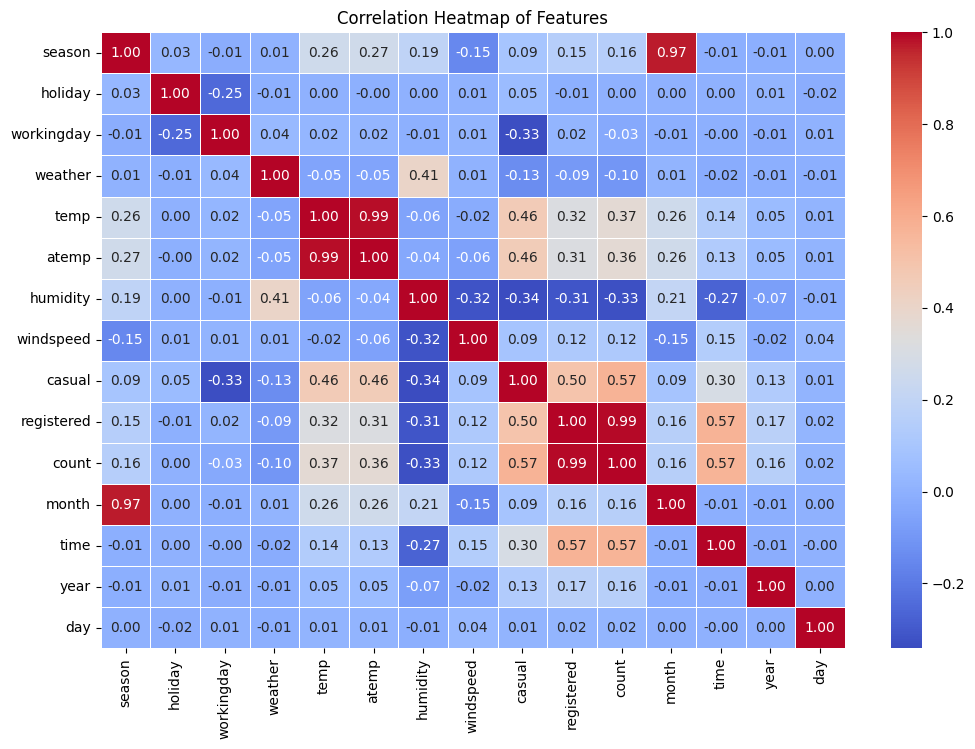

In [12]:
# Calculate the correlation matrix
correlation_matrix = train.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Features')
plt.show()

## We can draw the following obsevations from it:
1. The correlation between temp and atemp is very high so we can discard any of the variable
2. The correlation between count and time is highest and the correlation of count with year, month, temp,humidity is also significant

## Using three model to predict: RF, XGB and LGBM.

## First, extracting the month, hour, year, day from the datetime column in test.

In [15]:
test['datetime'] = pd.to_datetime(test['datetime']) # Converting the 'datetime' column to datetime format
# Create new features in test
test['month'] = add_month(test)
test['time'] = add_time(test)
test['year'] = add_year(test)
test['day'] = add_day(test)
# Now, drop the original 'datetime' column
test = test.drop(columns=['datetime'])
test.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,month,time,year,day
0,1,0,1,1,10.66,11.365,56,26.0027,1,0,2011,20
1,1,0,1,1,10.66,13.635,56,0.0000,1,1,2011,20
2,1,0,1,1,10.66,13.635,56,0.0000,1,2,2011,20
3,1,0,1,1,10.66,12.880,56,11.0014,1,3,2011,20
4,1,0,1,1,10.66,12.880,56,11.0014,1,4,2011,20


### Split the dataset into training and testing

In [16]:
# Split the dataset into features and target
X = train.drop(columns=['count', 'casual', 'registered']) # We remove columns that should not be used as input
y = train['count']  # Target variable (the 'count' column)

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Random Forest Model

In [17]:
# Create and train the Random Forest model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_rf_pred = rf_model.predict(X_test)

# Evaluate the Random Forest model
rf_mse = mean_squared_error(y_test, y_rf_pred)
rf_r2 = r2_score(y_test, y_rf_pred)

# Print the evaluation results
print(f'Random Forest Mean Squared Error: {rf_mse}')
print(f'Random Forest R-squared: {rf_r2}')

# Calculate RMSLE
rmsle = np.sqrt(mean_squared_log_error(y_test, y_rf_pred))
print(f"RMSLE en validación: {rmsle:.5f}")


# Generate predictions for the test set
test_preds = rf_model.predict(test)

# Create the output file for Kaggle
submission = pd.DataFrame({
    'datetime': pd.read_csv(test_path)['datetime'],
    'count': test_preds
})

submission.to_csv('submission_rf.csv', index=False)

print("Archivo de predicciones generado: rf_submission.csv")

Random Forest Mean Squared Error: 0.09988316133192404
Random Forest R-squared: 0.9471709077702029
RMSLE en validación: 0.08142
Archivo de predicciones generado: rf_submission.csv


## Apply scaling for XGBoost and LightGBM models

In [41]:
# Apply scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)
test = scaler.transform(test)

# Split for validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Extreme Gradient Boosting Model

In [42]:
# Train XGBoost model
xgb_model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict and evaluate XGBoost
xgb_preds_val = xgb_model.predict(X_test)
xgb_rmsle = np.sqrt(mean_squared_log_error(y_test, np.maximum(0, xgb_preds_val)))
print(f'XGBoost RMSLE: {xgb_rmsle:.5f}')

# Generate predictions for tests with XGBoost
test_preds_xgb = np.maximum(0, xgb_model.predict(test))

# Create file for Kaggle - XGBoost
submission_xgb = pd.DataFrame({'datetime': pd.read_csv(test_path)['datetime'], 'count': test_preds_xgb})
submission_xgb.to_csv('submission_xgb.csv', index=False)

print('¡Predicciones listas para Kaggle!')


XGBoost RMSLE: 0.07826
¡Predicciones listas para Kaggle!


## Light Gradient Boosting Machine Model

In [45]:
# Train LightGBM model
lgb_model = lgb.LGBMRegressor(n_estimators=1000, learning_rate=0.05, max_depth=15, random_state=42)
lgb_model.fit(X_train, y_train)

# Predict and evaluate LightGBM
lgb_preds_val = lgb_model.predict(X_test)
lgb_rmsle = np.sqrt(mean_squared_log_error(y_test, np.maximum(0, lgb_preds_val)))
print(f'LightGBM RMSLE: {lgb_rmsle:.5f}')

# Generate predictions for tests with LightGBM
test_preds_lgb = np.maximum(0, lgb_model.predict(test))

# Create file for Kaggle - LightGBM
submission_lgb = pd.DataFrame({'datetime': pd.read_csv(test_path)['datetime'], 'count': test_preds_lgb})
submission_lgb.to_csv('submission_lgb.csv', index=False)

print('¡Predicciones listas para Kaggle!')


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000584 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 293
[LightGBM] [Info] Number of data points in the train set: 8591, number of used features: 12
[LightGBM] [Info] Start training from score 4.562961


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM RMSLE: 0.07660


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


¡Predicciones listas para Kaggle!
